In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
f = open("./tsp.csv", "r")
lines = f.read().splitlines()
cities = []
for line in lines:
    line = line.split(",")
    cities.append([int(line[1]),int(line[2])])

In [7]:
n_cities = len(cities)
distance = [[0 for _ in range(n_cities)] for _ in range(n_cities)]
for i in range(n_cities):
    for j in range(n_cities):
        distance[i][j] = abs(cities[i][0] - cities[j][0]) + abs(cities[i][1] - cities[j][1]) 

In [104]:
def plot_path(path):
    coords = [cities[i] for i in path] # Берем координаты
    coords = np.array(coords)
    plt.scatter(coords[:,0], coords[:, 1])
    for i in range(len(coords)-1):
        city1 = coords[i]
        city2 = coords[i+1]
        plt.plot([city1[0],city2[0],city2[0]],[city1[1],city1[1],city2[1]]) # Строим две линии

In [31]:
def calculate_distance(path):
    dist = 0
    for i in range(len(path)-1):
        dist+=distance[path[i]][path[i+1]]
    return dist

# 1. (1 балл) Реализуйте Монте-Карло поиск.

27305


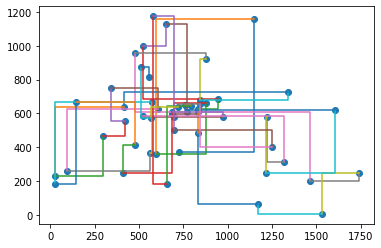

In [105]:
def monte_carlo(tries = 500000):
    best_path = []
    best_dist = 10000000
    for _ in range(tries):
        path = np.random.permutation(n_cities)
        dist = calculate_distance(path)
        if dist < best_dist:
            best_dist = dist
            best_path = path
    print(best_dist)
    plot_path(best_path)
monte_carlo()

# 2. (1 балл) Реализуйте поиск случайным блужданием.

In [89]:
def swap_random_pair(arr):
    arr = arr.copy()
    i, j = np.random.choice(len(arr), 2, replace = False)
    t = arr[i]
    arr[i] = arr[j]
    arr[j] = t
    return arr

26525


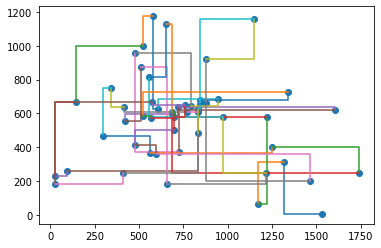

In [106]:
def random_walk(n_tries=500000):
    path = np.random.permutation(n_cities)
    best_path = path
    best_dist = calculate_distance(path)
    for _ in range(n_tries):
        path = swap_random_pair(path) # В случайном месте делаем шаг в другой город
        dist = calculate_distance(path)
        if dist < best_dist:
            best_dist = dist
            best_path = path
    print(best_dist)
    plot_path(best_path)
random_walk()

# 3. (2 балла) Реализуйте Hill Climb.

10880


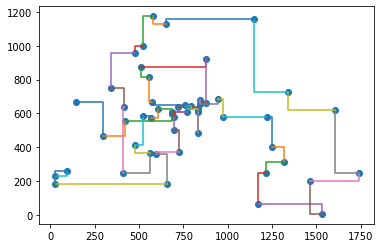

In [117]:
def hill_climb(starts = 15, climbers = 40, n_steps = 1000):
    best_path = None
    best_dist = 10000000 
    for _ in range(starts):
        path = np.random.permutation(n_cities)
        for _ in range(n_steps):
            local_best_dist = 10000000
            local_best_path = None
            paths = [swap_random_pair(path) for _ in range(climbers)]
            for p in paths:
                d = calculate_distance(p)
                if d < local_best_dist: # Ищем лучшее направление
                    local_best_dist = d
                    local_best_path = p
            path = local_best_path
            if local_best_dist < best_dist:
                best_dist = local_best_dist
                best_path = local_best_path
    print(best_dist)
    plot_path(best_path)
hill_climb()

# 4. (3 балла) Реализуйте ожиг (simulated annealing). Температурный режим отжига выберите самостоятельно.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


11310


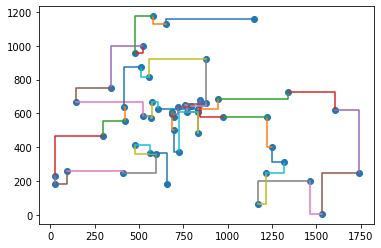

In [113]:
def annealing(max_t = 100, steps = 10000, n_checks = 20):
    path = np.random.permutation(n_cities)
    path_d = calculate_distance(path)
    best_path = path
    best_dist = path_d
    
    for t in np.linspace(max_t,0,steps):
        paths = [swap_random_pair(path) for _ in range(n_checks)]
        distances = [calculate_distance(p) for p in paths]
        probs = []
        for dist in distances:
            probs.append(np.exp((path_d-dist)/t))
        p_sum = sum(probs)
        if p_sum == 0 or np.isnan(probs).any():
            continue
        for i in range(len(probs)):
            probs[i] = probs[i]/p_sum
        if np.isnan(probs).any():
            continue
        new_p = np.random.choice(n_checks, 1, p = probs)[0]
        path = paths[new_p]
        path_d = distances[new_p]
        if path_d < best_dist:
            best_dist = path_d
            best_path = path
    print(best_dist)
    plot_path(best_path)
annealing()

# 5. (3 балла) Реализуйте генетический алгоритм. 

11855


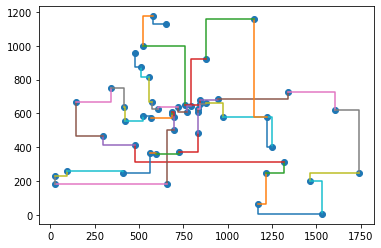

In [128]:
def breed(path1, path2):
    i = np.random.choice(len(path1), 1)[0]
    res = np.concatenate([path1[:i], path2[i:]]) # Кусок одной, кусок другой
    used = []
    unused = [i for i in range(len(path1))]
    for i in range(len(res)): # Убираем коллизии
        n = res[i]
        if n in used:
            res[i] = -1
        else:
            used.append(n)
            unused.remove(n)
    for i in range(len(res)):
        if res[i] == -1:
            res[i] = unused[0]
            unused.pop(0)
    return res

def evolutionary(population_size = 50, steps = 100000):
    best_path = None
    best_dist = 10000000
    population = [np.random.permutation(n_cities) for _ in range(population_size)]
    for _ in range(steps):
        distances = [calculate_distance(p) for p in population]
        distances = sorted(list(zip(distances, [i for i in range(population_size)])))
        if distances[0][0] < best_dist:
            best_dist = distances[0][0]
            best_path = population[distances[0][1]]
        br1 = population[distances[0][1]]
        br2 = population[distances[1][1]] # Breed best ones
        mut_i = np.random.choice(population_size, 5,replace = False)
        for i in mut_i:
            population[i] = swap_random_pair(population[i])
        population[distances[-1][1]] = breed(br1, br2) # Replace worst one
    print(best_dist)
    plot_path(best_path)
evolutionary()